https://medium.com/@martinpella/customers-tweets-classification-41cdca4e2de
Through sentiment analysis, companies can automatically process what their consumers write in natural language and get valuable insights in order to take decisions.

#### Data set
We will use tweets from major U.S. airlines customers scraped from February 2015 and provided by Crowdflower. The data set contains 14640 rows and 20 columns with the following data for each tweet:
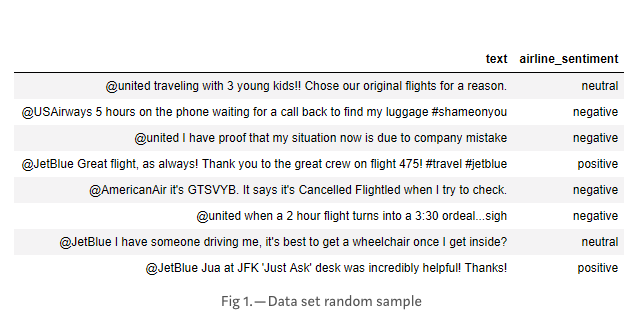
Our goal is to build a model that predicts if tweet’s writer opinion is positive, neutral or negative.

#### Load data

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os, string, collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import utils
from utils import *

import snowballstemmer
from nltk.corpus import stopwords

from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn import metrics
from keras.wrappers.scikit_learn import KerasClassifier

from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, load_model
from keras.layers.embeddings import Embedding
from keras.layers import Flatten, Dense, Dropout, Convolution1D, MaxPooling1D, SpatialDropout1D, Input 
from keras.layers import GlobalMaxPooling1D, concatenate, LSTM, Bidirectional
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [2]:
raw_df = pd.read_csv('data/Airline-Sentiment-2-w-AA.csv', encoding='ISO-8859-1')

In [3]:
raw_df.shape

(14640, 20)

In [4]:
raw_df.sample(5)

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,airline_sentiment,airline_sentiment:confidence,negativereason,negativereason:confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone
2513,681451882,False,finalized,3,2/25/15 1:45,negative,1.0,Cancelled Flight,1.0000,United,NaN,calebkelley,NaN,0,@united My flight was Cancelled Flighted and I...,NaN,2/21/15 6:59,5.691490e+17,"Springfield, MO",NaN
4826,681454821,False,finalized,3,2/25/15 9:39,negative,1.0,longlines,0.6723,Southwest,NaN,joekidd21,NaN,0,@SouthwestAir @fly2midway 45 minute wait for m...,"[41.79410567, -87.74243312]",2/22/15 19:10,5.696960e+17,NaN,NaN
4717,681454710,False,finalized,3,2/25/15 9:33,positive,1.0,NaN,NaN,Southwest,NaN,EASmith_,NaN,0,@SouthwestAir Glad to know I'll be flying the ...,NaN,2/23/15 8:55,5.699030e+17,"Columbus, OH",Quito
14502,681679661,False,finalized,3,2/25/15 19:25,neutral,1.0,NaN,NaN,American,NaN,mareyes15,NaN,0,@AmericanAir are flights from Columbus Ohio to...,NaN,2/22/15 13:14,5.696060e+17,NaN,Eastern Time (US & Canada)
7704,681458448,False,finalized,3,2/25/15 10:03,positive,1.0,NaN,NaN,Delta,NaN,JummyTV,NaN,0,@JetBlue @L_Burley11 -- the best!!!,NaN,2/21/15 19:05,5.693320e+17,"Washington, DC",Eastern Time (US & Canada)


In [5]:
raw_df.isnull().sum()

_unit_id                            0
_golden                             0
_unit_state                         0
_trusted_judgments                  0
_last_judgment_at                  56
airline_sentiment                   0
airline_sentiment:confidence        0
negativereason                   5462
negativereason:confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_id                            0
tweet_location                   4733
user_timezone                    4820
dtype: int64

In [6]:
raw_df['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

In [7]:
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
sns.set_style(style='whitegrid')

In [8]:
df = raw_df[['text', 'airline_sentiment']].copy()

In [9]:
df.shape

(14640, 2)

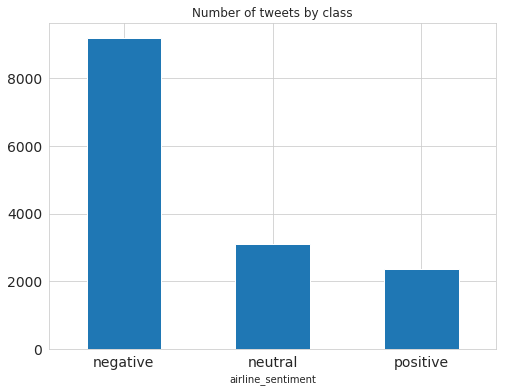

In [10]:
df.groupby(['airline_sentiment']).count().plot(kind='bar', figsize=(8, 6), rot=0, legend=False, title='Number of tweets by class');

In [11]:
pd.set_option('display.max_colwidth', -1)

In [12]:
df.sample(5)

,text,airline_sentiment
5500,"@SouthwestAir 14 hours???? Sorry don't get it. Oh well. Screw the weekend in Az right? Eat the hotel, no problem.",negative
2045,@united it's disgusting and unconscionable the treatment I've received tonight.,negative
5488,@SouthwestAir @SwagglikeBean take me here,neutral
14521,@AmericanAir how does one book a ticket online and put it on hold? Does that require that I pay for the ticket?,neutral
3671,@united why does it cost $547 to change the city of origin when the same flight on http://t.co/8FMZZOltv9 costs $165 #customerservicefail,negative


### Pre-processing

In [13]:
le = LabelEncoder()
df['target'] = le.fit_transform(df['airline_sentiment'])

In [14]:
PATH = os.getcwd()
print(PATH)

/home/nbuser/library/A  Sample Project/Customers’ tweets classification


In [15]:
import sys
sys.path.append(PATH + '/')
from utils import *

### Text cleaning 
Tweets contain different kind of noise that can harm machine learning algorithms performance. We need to carefully get rid of them. To this particular task we will take advantage of regular expressions.

Mentions: can lead to overfitting
- text = re.sub(r'@\w+', '', text)
Symbols and digits:
- text = re.sub('[^a-zA-Z\s]', '', text)
Extra white spaces:  after applying previous steps, texts could end up with extra white spaces that later the tokenizer will split as words. We remove them.
- text = re.sub("\s+", '', text)
- text = text.lstrip()
- text = text.rstrip()

Lowercase: text = text.lower()

Fixing words: 
- text = re.sub(r'\bcudtomers\b', 'customers', text)
- text = re.sub(r'\bppl\b', 'people', text)
- text = re.sub(r'\basap\b', 'as soon as possible', text)
- text = re.sub(r'\biphone\b', 'phone', text)

In [16]:
ct = TextCleaner()
df['clean_text'] = ct.transform(df['text'])

#### Tokenization
To segment text into tokens (words in this case)

In [17]:
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')

def tokenize(s): 
    return re_tok.sub(r' \1 ', s).split()

In [18]:

df['tokenized'] = df['clean_text'].apply(lambda row: tokenize(row))

#### Stopwords

Most common words are filtered out.  To do that, NLTK stopwords list is used. We also add ‘amp’, ‘rt’ and ‘cc’ because those terms appears frequently in tweets but do not contribute to predict the sentiment. On the other hand ‘no’ and ‘not’ are kept since they could give information about negative opinions.

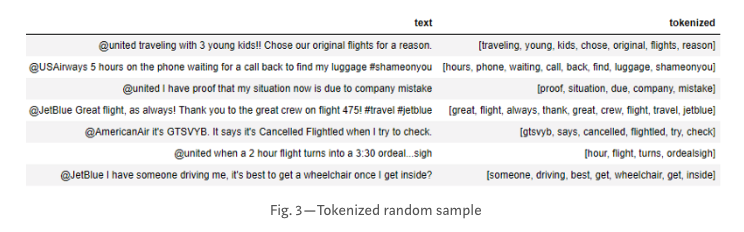

In [19]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/nbuser/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [20]:
from nltk.corpus import stopwords

In [21]:
stop = set(stopwords.words('english'))
stop.update(['amp', 'rt', 'cc'])
stop = stop - set(['no', 'not'])

In [22]:
def remove_stopwords(row):
    return [t for t in row if t not in stop]

In [23]:
df['tokenized'] = df['tokenized'].apply(lambda row: remove_stopwords(row))

In [24]:
pd.set_option('display.max_colwidth', -1)

In [25]:
df[['text', 'tokenized']].head()

,text,tokenized
0,@VirginAmerica What @dhepburn said.,[said]
1,@VirginAmerica plus you've added commercials to the experience... tacky.,"[plus, youve, added, commercials, experience, tacky]"
2,@VirginAmerica I didn't today... Must mean I need to take another trip!,"[didnt, today, must, mean, need, take, another, trip]"
3,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse","[really, aggressive, blast, obnoxious, entertainment, guests, faces, little, recourse]"
4,@VirginAmerica and it's a really big bad thing about it,"[really, big, bad, thing]"


In [31]:
def update_vocab_counter(row):
    for word in row:
        vocab_counter[word] += 1#luc sau minh se truyen vao vocab_counter = collections.Counter()

In [32]:
vocab_counter = collections.Counter()
df['tokenized'].apply(update_vocab_counter)
vocab = sorted(vocab_counter, key=vocab_counter.get, reverse=True)

A counter is a container that stores elements as dictionary keys, and their counts are stored as dictionary values.

In [34]:
myList = [1,1,2,3,4,5,3,2,3,4,2,1,2,3]
print(collections.Counter(myList))

Counter({2: 4, 3: 4, 1: 3, 4: 2, 5: 1})


In [35]:
print(collections.Counter(myList).items())

dict_items([(1, 3), (2, 4), (3, 4), (4, 2), (5, 1)])


In [36]:
print(collections.Counter(myList).keys())

dict_keys([1, 2, 3, 4, 5])


In [37]:
len(vocab)

12390

We limit the dictionary size to the top 5000 most frequent tokens

In [38]:
max_words = 5000

Dictionary that map each token with their id

In [39]:
w2id = {w:i for i, w in enumerate(vocab[:max_words])}

We will replace each token out of top 5000 with 'unk'

In [40]:
w2id['unk'] = -1

We transform each token by their id

In [41]:
def transform_to_ids(row):
    return [w2id[w] if w in w2id else w2id['unk'] for w in row]

In [42]:
df['tokenized_int'] = df['tokenized'].apply(lambda x: transform_to_ids(x))

In [43]:
df['tokenized_int'] .head()

0    [127]                                             
1    [408, 409, 959, 2183, 110, -1]                    
2    [104, 36, 635, 429, 22, 72, 67, 107]              
3    [61, 3262, 4060, 4061, 823, 2754, 3263, 366, 2418]
4    [61, 350, 119, 367]                               
Name: tokenized_int, dtype: object

#### Tweets length

In [44]:
lens = df['tokenized_int'].apply(lambda x: len(x))

In [45]:
min(lens), max(lens), np.mean(lens)

(0, 21, 8.987636612021857)

#### We set 20 as max length

In [46]:
maxlen = 20

#### Train, test split

In [47]:
X_train, X_test, y_train, y_test = train_test_split(df['tokenized_int'].values, df['target'].values, test_size=0.25, random_state=0)

Since we need that each document contains a fixed number of tokens (20), we fill with -1 (id that represents 'unk') every token with size < 20

In [48]:
x_train = pad_sequences(X_train, maxlen=maxlen, value=-1)
x_test = pad_sequences(X_test, maxlen=maxlen, value=-1)

We one-hot encode target classes

In [49]:
dummy_y = np_utils.to_categorical(y_train)
dummy_y_test = np_utils.to_categorical(y_test)

#### Linear model

The first approach is to create a neural network with a 50 dimension embedding layer as input and no hidden layers. This is equivalent as apply logistic regression over word vectors rather than one hot encoded vectors.

In [50]:
def baseline_model():
    model = Sequential([Embedding(input_dim=max_words, output_dim=50, input_length=maxlen),
                        Flatten(),
                        Dense(3, activation='softmax')])

    model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
    
    return model

For all the models we use cross-validation with 5 folds

In [51]:
estimator = KerasClassifier(build_fn=baseline_model, epochs=5, batch_size=100, verbose=0)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

In [52]:
results = cross_val_score(estimator, x_train, y_train, cv=kfold)

InvalidArgumentError: indices[0,0] = -1 is not in [0, 5000)
	 [[{{node embedding_1/embedding_lookup}} = GatherV2[Taxis=DT_INT32, Tindices=DT_INT32, Tparams=DT_FLOAT, _class=["loc:@training/Adam/Assign_2"], _device="/job:localhost/replica:0/task:0/device:CPU:0"](embedding_1/embeddings/read, embedding_1/Cast, training/Adam/gradients/embedding_1/embedding_lookup_grad/concat/axis)]]